In [1]:
pip install transformers

     |████████████████████████████████| 4.0 MB 7.6 MB/s 
     |████████████████████████████████| 77 kB 8.2 MB/s 
     |████████████████████████████████| 6.5 MB 55.3 MB/s 
     |████████████████████████████████| 895 kB 58.7 MB/s 
     |████████████████████████████████| 596 kB 64.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
pip install emoji

     |████████████████████████████████| 175 kB 8.9 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=26747e013b7bb57a57e9fbd45b1079394e07d5dfb78c724e096fc1140a58f4f3
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


### 1. Import packages

In [3]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader
from transformers import AdamW
import pandas as pd
import torch
import random
import emoji
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import json
from collections import Counter
import re
import os
from string import punctuation
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

In [4]:
SEED = 9999
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

### 2. Load and clean data

In [5]:
def remove_punct(s):
    punct_pattern = re.compile(r'[^\w\s\#]')
    no_punct = punct_pattern.sub(r'', s)
    return no_punct

In [6]:
def remove_emoji(string):
    allchars = [str for str in string]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI['en']]
    clean_text = ' '.join([str for str in string.split() if not any(i in str for i in emoji_list)])
    return clean_text

In [7]:
def read_data(data, test=False):
    texts = []
    labels = []
    if test == False:
        data.dropna(subset=['tidyTweet', 'Label'], inplace=True)
    else:
        data.dropna(subset=['tidyTweet'], inplace=True)

    for i in tqdm(data.itertuples(), total=len(data)):
        line = getattr(i, 'tidyTweet')
        line = line.strip()
        if not line:
            continue
        line = remove_emoji(line)
        line = remove_punct(line).strip()
        texts.append(line)

        if test == False:
            label = getattr(i, 'Label')
            labels.append(label)
            if label == 1.0:
                texts.extend([line] * 2)
                labels.extend([label] * 2)

    if test == False:
        assert len(texts) == len(labels)
        return texts, labels
    else:
        return texts

In [8]:
df = pd.read_csv('../dataset.csv')
df.groupby(['Label']).count()

,id,date,tweet,tidyTweet
Label,,,,
0.0,8865,8865,8865,8864
1.0,2884,2884,2884,2883


In [9]:
texts, labels = read_data(df)

  0%|          | 0/11747 [00:00<?, ?it/s]

In [10]:
Counter(labels)

Counter({0.0: 8864, 1.0: 8649})

### 3. Split train validation dataset

In [11]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels,
                                                                    test_size=0.2,
                                                                    random_state=43,
                                                                    stratify=labels)

In [12]:
len(train_labels),len(val_labels),len(train_texts),len(val_texts)

(14010, 3503, 14010, 3503)

In [13]:
max([len(item) for item in texts])

286

### 4. Tokenization

In [14]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [15]:
train_encodings = tokenizer(train_texts,
                            truncation=True,
                            padding='max_length',
                            max_length=128)
val_encodings = tokenizer(val_texts,
                          truncation=True,
                          padding='max_length',
                          max_length=128)

In [16]:
label_ids = {item: idx for idx, item in enumerate(set(sorted(labels)))}
label_ids

{0.0: 0, 1.0: 1}

### 5. Generate dataset

In [17]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        idx = int(idx)
        item = {
            key: torch.tensor(val[idx])
            for key, val in self.encodings.items()
        }
        if self.labels is not None:
            item['labels'] = torch.tensor(label_ids[self.labels[idx]])
        return item

    def __len__(self):
        return len(self.encodings.input_ids)

In [18]:
train_dataset = Dataset(train_encodings, train_labels)
val_dataset = Dataset(val_encodings, val_labels)

### 6. Dataloader

In [19]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### 7. Load pretrained model

In [20]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_ids))
model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### 8. Evaluation

In [21]:
@torch.no_grad()
def eval_model(model, eval_loader):
    model.eval()
    labels = []
    preds = []
    eval_loss = 0
    for batch in eval_loader:
        input_ids = batch['input_ids'].to(device)
        batch_labels = batch['labels'].to(device)
        labels.extend(batch_labels.cpu().numpy())
        outputs = model(input_ids=input_ids, labels=batch_labels)
        eval_loss += outputs.loss.item()
        preds.extend(torch.argmax(outputs.logits, dim=-1).cpu().numpy())

    eval_loss = eval_loss / len(val_dataset)
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')
    return accuracy, precision, recall, f1, eval_loss

### 9. Train the model

In [22]:
epoch = 4
lr = 1e-4
path = 'model_best_bert'
best_acc = 0
train_losses = []
eval_stats = {'Epoch':[], 'Loss':[], 'Accuracy':[], 'Precision':[], 'Recall':[], 'F1':[]}

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
                                 'weight_decay_rate': 0.01}, 
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
                                 'weight_decay_rate': 0.0}]

optim = AdamW(optimizer_grouped_parameters, lr=lr)
writer = SummaryWriter(comment='-bert-ep{}-bs{}-lr{}'.format(epoch, batch_size, lr))

for e in tqdm(range(epoch), desc='Epoch'):
    train_loss = 0
    model.train()
    for idx, batch in tqdm(enumerate(train_loader),
                           total=len(train_texts) // batch_size,
                           desc='Batch'):
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()
        optim.step()
    
    train_loss = train_loss / len(train_dataset)
    train_losses.append(train_loss)

    accuracy, precision, recall, f1, eval_loss = eval_model(model, eval_loader)

    eval_stats['Epoch'].append(e)
    eval_stats['Loss'].append(eval_loss)
    eval_stats['Accuracy'].append(accuracy)
    eval_stats['Precision'].append(precision)
    eval_stats['Recall'].append(recall)
    eval_stats['F1'].append(f1)

    writer.add_scalar('train_loss', train_loss, e)
    writer.add_scalar('accuracy', accuracy, e)
    writer.add_scalar('precision', precision, e)
    writer.add_scalar('recall', recall, e)
    writer.add_scalar('f1', f1, e)

    print(f'Epoch:{e+1}/{epoch}')
    print('Train loss:', train_loss)
    print('Validation loss:', eval_loss)
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1:', f1)
    print()

    if accuracy > best_acc:
        model.save_pretrained(path)  
        tokenizer.save_pretrained(path)
        best_acc = accuracy

print('Best Accuracy:', best_acc)
print('Finished Training.')

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Batch:   0%|          | 0/437 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch:1/4
Train loss: 0.021821407485569825
Validation loss: 0.021790300305829603
Accuracy: 0.49386240365401085
Precision: 0.24693120182700543
Recall: 0.5
F1: 0.33059430536976875



Batch:   0%|          | 0/437 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch:2/4
Train loss: 0.021788680234353597
Validation loss: 0.02176480881323176
Accuracy: 0.5061375963459892
Precision: 0.2530687981729946
Recall: 0.5
F1: 0.3360500379075057



Batch:   0%|          | 0/437 [00:00<?, ?it/s]

Epoch:3/4
Train loss: 0.02171437453151515
Validation loss: 0.021768220775031443
Accuracy: 0.49386240365401085
Precision: 0.24693120182700543
Recall: 0.5
F1: 0.33059430536976875



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Batch:   0%|          | 0/437 [00:00<?, ?it/s]

Epoch:4/4
Train loss: 0.02174182535919609
Validation loss: 0.02180394391621517
Accuracy: 0.5061375963459892
Precision: 0.2530687981729946
Recall: 0.5
F1: 0.3360500379075057

Best Accuracy: 0.5061375963459892
Finished Training.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
train_losses

[0.021821407485569825,
 0.021788680234353597,
 0.02171437453151515,
 0.02174182535919609]

In [24]:
eval_stats

{'Accuracy': [0.49386240365401085,
  0.5061375963459892,
  0.49386240365401085,
  0.5061375963459892],
 'Epoch': [0, 1, 2, 3],
 'F1': [0.33059430536976875,
  0.3360500379075057,
  0.33059430536976875,
  0.3360500379075057],
 'Loss': [0.021790300305829603,
  0.02176480881323176,
  0.021768220775031443,
  0.02180394391621517],
 'Precision': [0.24693120182700543,
  0.2530687981729946,
  0.24693120182700543,
  0.2530687981729946],
 'Recall': [0.5, 0.5, 0.5, 0.5]}

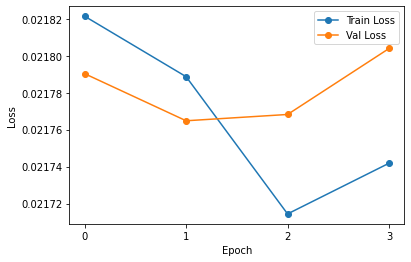

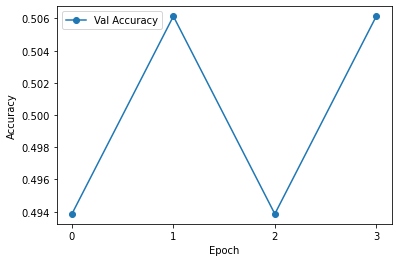

In [25]:
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(eval_stats['Loss'], label='Val Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(eval_stats['Epoch'])
plt.legend()
plt.show()

plt.plot(eval_stats['Accuracy'], label='Val Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(eval_stats['Epoch'])
plt.legend()
plt.show()

In [26]:
# output training results
stats_output_path = f'./{path}/e{epoch}_bs{batch_size}_lr{lr:.0e}'
if not os.path.exists(stats_output_path):
    os.makedirs(stats_output_path)

f = open(f'{stats_output_path}/train_losses_e{epoch}_bs{batch_size}_lr{lr:.0e}', 'w+')
f.write(json.dumps(train_losses))
f.close()
f = open(f'{stats_output_path}/eval_stats_e{epoch}_bs{batch_size}_lr{lr:.0e}', 'w+')
f.write(json.dumps(eval_stats))
f.close()

### 10. Prediction of test dataset

In [27]:
def test_model(test_data):
    for data in test_data:
        print(data)
        test_df = pd.read_csv('../' + data)
        test_texts = read_data(test_df, test=True)
        test_encodings = tokenizer(test_texts,
                                truncation=True,
                                padding='max_length',
                                max_length=128)
        test_dataset = Dataset(test_encodings)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        model.eval()
        test_predictions = []
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            with torch.no_grad():
                outputs = model(input_ids)
            test_predictions.extend(torch.argmax(outputs.logits, dim=-1).cpu().numpy())

        test_pred_uniq = np.unique(test_predictions, return_counts=True)
        for l in test_pred_uniq[0]:
            print('Test Label:', l)
            print('Count:', test_pred_uniq[1][np.where(test_pred_uniq[0]==l)].item())
            print('Percentage:', test_pred_uniq[1][np.where(test_pred_uniq[0]==l)].item() / np.sum(test_pred_uniq[1]))
        test_df_labeled = pd.concat((test_df, pd.Series(test_predictions, name='label')), axis=1)
        test_df_labeled.to_csv(data.split('.')[0] + '_labeled.csv', index=False)
        # print(test_df_labeled.head())
        print()

In [28]:
test_data = ['test_truckers_data.csv', 'test_covid_data.csv']
test_model(test_data)

test_truckers_data.csv


  0%|          | 0/1803 [00:00<?, ?it/s]

Test Label: 0
Count: 1803
Percentage: 1.0

test_covid_data.csv


  0%|          | 0/1954 [00:00<?, ?it/s]

Test Label: 0
Count: 1954
Percentage: 1.0



In [ ]:
from google.colab import files
!zip -r /content/model_best_bert.zip /content/model_best_bert
files.download("/content/model_best_bert.zip")
files.download("/content/test_covid_data_labeled.csv")
files.download("/content/test_truckers_data_labeled.csv")

  adding: content/model_best_bert/ (stored 0%)
  adding: content/model_best_bert/tokenizer_config.json (deflated 43%)
  adding: content/model_best_bert/pytorch_model.bin